In [1]:
from sklearn.decomposition import PCA
import data_prep as dp
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.dates as mdates









pd.set_option('display.max_columns', 1500) 
pd.set_option('display.max_rows', 1500) 

In [ ]:
!pip install openpyxl

In [74]:
def itr(ac,num_tac): # num_tac = possible selections
    spm = 60000/620/8/num_tac #selections per minute
    itr = (np.log2(num_tac)+ ac*np.log2(ac)+ (1-ac)* np.log2((1-ac)/(num_tac-1)))*spm 
    return itr




def boxplot_accuracy(data,name:str,fname:str): #fnme = formatted name
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(12,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=15,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-15,110)
    ax.axhline(y=-5,c='k', lw=0.5)
    ax.axvspan(int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)-0.25,int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)+0.25, facecolor="#808080", alpha=0.3)
    for i,mean in enumerate(sorted_classifiers[:,0]):
        ax.text(x=i+0.9,y=-11,s=str(round(float(mean)*100)))
    ax.text(x=-0.30,y=-11,s="Ø in %")
    #fig.suptitle(fname)
    plt.savefig(r"created_data\Graphics\Acc_"+name+".svg",format='svg',bbox_inches="tight",pad_inches=0.2)

def bar_itr(data,name:str):
    fig,ax = plt.subplots(figsize=(16,5))

    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["ITR"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    values = [float(i) for i in sorted_classifiers[:,0]]
    df_list = []

    ax.bar(sorted_classifiers[:,1],values,width =0.25)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("ITR (Bits/Minuite)")
    fig.suptitle("ITR " + name)
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\ITR_boxplot_"+name+".svg",fromat="svg",bbox_inches="tight",pad_inches=0.2)

    
def plot_timeline_without_accuracy(tar_df, ntar_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a","#702963"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ##ax.text(3, 8, 'R² = '+ str(round(lr.score(x,y),3), style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    print(lr.score(x,y))
    ax.axvline(x=tar_df.index.values[12],alpha=0.65,zorder=0,c=col_list[2],ls="--",lw=1) # electrode set b    
    ax.axvline(x=tar_df.index.values[21],alpha=0.65,zorder=0,c=col_list[3], ls="--",lw=1)
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65)
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65)
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=1.5,alpha=0.65)
    lgd =ax.legend(["Electrode SetB","Tactor Relocation","Difference Trend ()", "Target", "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")
    #specify x ticks
    #ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))#("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_xlabel("Dates")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"created_data\Graphics\Timeline.svg",bbox_inches="tight",pad_inches=0.2,format="svg")    
    
    

def Per2Ac(x):
    return x*25

def Ac2Per(x):
    return x/25


def plot_timeline(tar_df, ntar_df,oa_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a","#702963","k"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,6))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ##ax.text(3, 8, 'R² = '+ str(round(lr.score(x,y),3), style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    print("R² of the linear regression: {}".format(lr.score(x,y)))
    

    ax.axvline(x=tar_df.index.values[12],alpha=0.65,zorder=0,c=col_list[2],ls="--",lw=1, label= "Electrode SetB") # electrode set b    
    ax.axvline(x=tar_df.index.values[21],alpha=0.65,zorder=0,c=col_list[3], ls="--",lw=1,label = "Tactor Relocation")
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65, label="Target")
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65, label = "NonTarget")
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=1.5,alpha=0.65, label = "Difference Trend")
    oa = ax.plot(oa_df.index, oa_df,color=col_list[4],lw=0.7, label = "Online Accuracy")
    lgd =ax.legend( ncol=6, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("Amplitude [µV]")
    #specify x ticks
    #ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))#("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    sec_ax = ax.secondary_yaxis("right",functions= (Per2Ac,Ac2Per))
    sec_ax.set_ylabel("Accuracy [%]")
    ax.set_xlabel("Dates")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"created_data\Graphics\Timeline"+title+".svg",bbox_inches="tight",pad_inches=0.2,format="svg")

# Load Data for the first time: Amplitudes + Classifiers

## relabel data: 
add dates to amplitudes
single calibration data was split into two sets of electrodes, comnbine them

In [ ]:
def load_session_dates():
    with open(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\date_dict.pickle", "rb") as file:
        SESS_DATES = pickle.load(file)
    return SESS_DATES

SESS_DATES = load_session_dates()
amp = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600.csv")
amp["Dates"] = amp["Session"].replace(SESS_DATES)

amp.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600_with_dates.csv",index=False)


all_acc =  pd.read_csv(r"created_data\Classifier_Results\current\accuracies.csv")
all_acc["Condition"] = all_acc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
#change NaN values in SWLDA (those sessions in which the SWLDA was unable to form a classifier)
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)
all_acc.to_csv(r"created_data\Classifier_Results\current\accuracies_rightlabel.csv",index=False)
all_acc["Condition"].isnull().any().sum()

#create a df with all the averages and stds
overview = pd.DataFrame()
overview["sess3_ac"] = sess3.groupby("Classifier").mean()["Accuracy"]
overview["sess3_std"] = sess3.groupby("Classifier").std()["Accuracy"]
overview["sess1_ac"] = sess1.groupby("Classifier").mean()["Accuracy"]
overview["sess1_std"] = sess1.groupby("Classifier").std()["Accuracy"]
overview["single3_ac"] = single3.groupby("Classifier").mean()["Accuracy"]
overview["single3_std"] = single3.groupby("Classifier").std()["Accuracy"]
overview["single1_ac"] = single1.groupby("Classifier").mean()["Accuracy"]
overview["single1_std"] = single1.groupby("Classifier").std()["Accuracy"]
overview.to_csv(r"created_data\Classifier_Results\current\accuracies_overview.csv")

# Online Data - Amplitudes + Accuracy

### Plot average P300

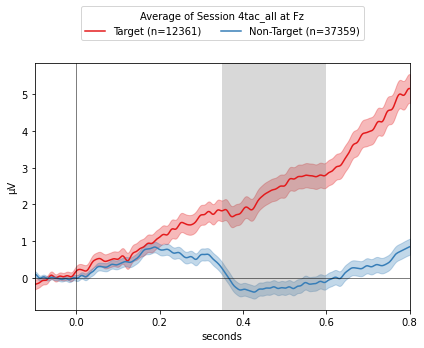

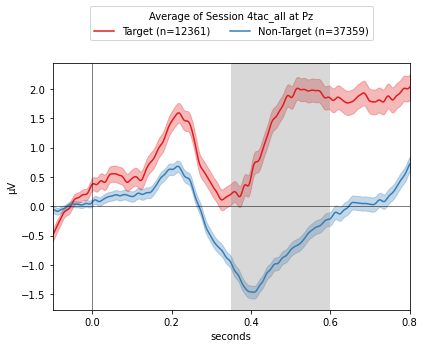

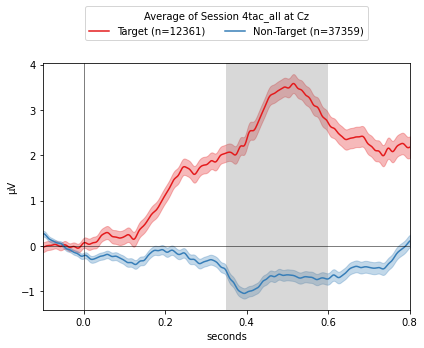

In [20]:
#4 tactors
sess_list = range(1,31)
data_origin = r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\mne_raw_4tac"

data_path = []
for sess in sess_list:
    data_path.append(data_origin + r"\4tac_Calib_S" + str(sess).zfill(3) + ".pickle")
    data_path.append(data_origin + r"\4tac_Copy_S" + str(sess).zfill(3) + ".pickle")

dp.investigate(data_path, sess_name="4tac_all",
               electrodes_to_plot = ["Fz","Pz","Cz"],
               plot_amplitude = True,
               plot_mne =False,
               plot_woi_shift=False,
               plot_r2=False,
               save_averages=True,
               mean_amplitude_tactilos=True)

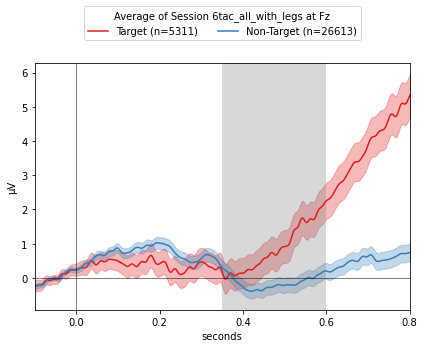

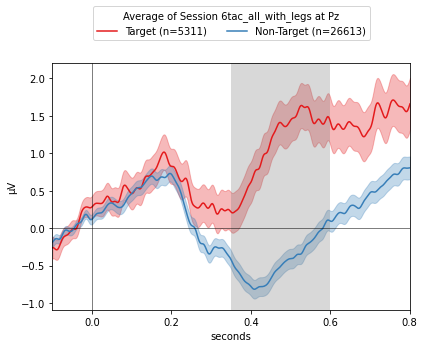

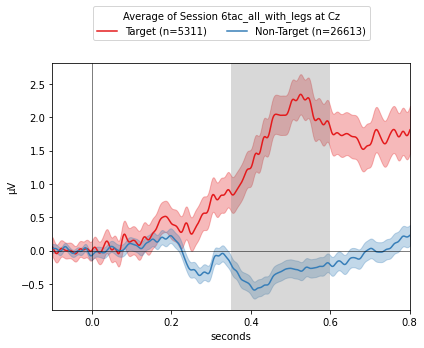

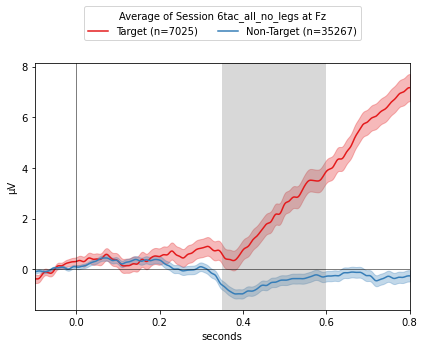

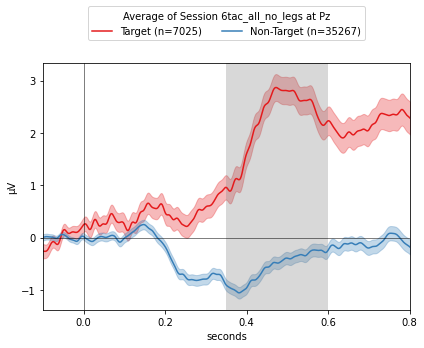

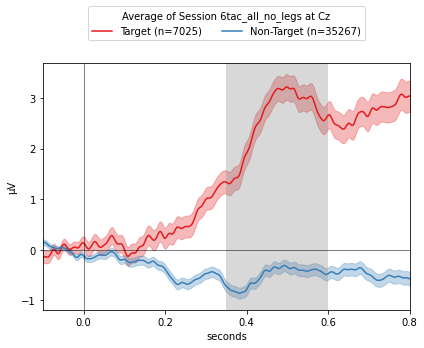

In [6]:
#6 tactors - legs included
sess_list = range(1,26)
excluded_sessions = [4,7,10,11,12,16,18,19,20,32] #some sessions were training session which followed after the standard protocol (they happend on the same day and are excluded from analysis)
data_origin = r"G:\Meine Ablage\PhD\P300\Data\LIS_Paper\mne_raw_6tac"

data_path = []
for sess in sess_list:
    if sess in excluded_sessions:
        continue
    data_path.append(data_origin + r"\Calib_S" + str(sess).zfill(3) + ".pickle")
    data_path.append(data_origin + r"\Free_S" + str(sess).zfill(3) + ".pickle")

dp.investigate(data_path, sess_name="6tac_all_with_legs",
               electrodes_to_plot = ["Fz","Pz","Cz"],
               plot_amplitude = True,
               plot_mne =False,
               plot_woi_shift=False,
               plot_r2=False,
               save_averages=True,
               mean_amplitude_tactilos=True)

#6 tactors - legs excluded
sess_list = range(26,50)

data_path = []
for sess in sess_list:
    if sess in excluded_sessions:
        continue
    data_path.append(data_origin + r"\Calib_S" + str(sess).zfill(3) + ".pickle")
    data_path.append(data_origin + r"\Free_S" + str(sess).zfill(3) + ".pickle")

dp.investigate(data_path, sess_name="6tac_all_no_legs",
               electrodes_to_plot = ["Fz","Pz","Cz"],
               plot_amplitude = True,
               plot_mne =False,
               plot_woi_shift=False,
               plot_r2=False,
               save_averages=True,
               mean_amplitude_tactilos=True)

### Load Online Accuracy 6 tactors

In [95]:
oa = pd.read_csv(r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\online_accuracy.csv", sep=";")
oa = oa.set_index(pd.to_datetime(oa.Datum,format="%d.%m.%Y"),drop=True)
oa["Online Accuracy"] = oa["Online Accuracy"].str.rstrip('%').astype('float') / 100.0
oitr = itr(oa["Online Accuracy"],6)
oa = oa["Online Accuracy"]*4 # to map on the primary y-axis


### Load Amplitudes  6 tactors

In [96]:
amp = pd.read_csv(r"created_data\Amplitudes\average_amplitudes_350_600_with_dates.csv")
t = amp.loc[(amp.Condition=="Target")&(amp.Electrode=="Cz")]
nt= amp.loc[(amp.Condition=="nonTarget")&(amp.Electrode=="Cz")]

In [97]:
t_mean = t.groupby('Dates').mean()
t_mean = t_mean.set_index(pd.to_datetime(t_mean.index,dayfirst=True),drop=True)
t_mean = t_mean.sort_index()
nt_mean = nt.groupby('Dates').mean()
nt_mean = nt_mean.set_index(pd.to_datetime(nt_mean.index,dayfirst=True),drop=True)
nt_mean = nt_mean.sort_index()

### Plot Timeline  6 tactors

R² of the linear regression: 0.17301501415860188


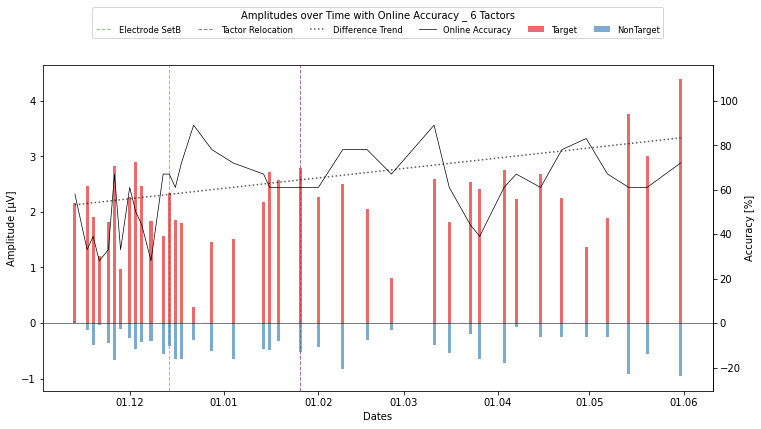

In [98]:
plot_timeline(t_mean,nt_mean,oa,"Cz","Amplitudes over Time with Online Accuracy _ 6 Tactors")

### same procedure 4 tactors

In [99]:
oa = pd.read_csv(r"G:\Meine Ablage\PhD\P300\LIS_Paper\Data\4tac_online_accuracy.csv", sep=";")
dates = oa.Date
dates.index += 1
SESS_DATES = dates.to_dict()
oitr = itr(oa["Accuracy"],4)
oa = oa.set_index(pd.to_datetime(oa.Date,format="%d.%m.%Y"),drop=True)
#oa["Accuracy"] = oa["Accuracy"].str.rstrip('%').astype('float') / 100.0
oa = oa["Accuracy"]*4 # to map on the primary y-axis

In [100]:
amp = pd.read_csv(r"created_data\Amplitudes\average_amplitudes_350_600_4tac_all.csv")
amp["Dates"] = amp["Session"].replace(SESS_DATES)
amp["Dates"]  = pd.to_datetime(amp["Dates"],format="%d.%m.%Y")
t = amp.loc[(amp.Condition=="Target")&(amp.Electrode=="Cz")]
nt= amp.loc[(amp.Condition=="nonTarget")&(amp.Electrode=="Cz")]

t_mean = t.groupby('Dates').mean()
t_mean = t_mean.set_index(pd.to_datetime(t_mean.index,dayfirst=True),drop=True)
t_mean = t_mean.sort_index()
nt_mean = nt.groupby('Dates').mean()
nt_mean = nt_mean.set_index(pd.to_datetime(nt_mean.index,dayfirst=True),drop=True)
nt_mean = nt_mean.sort_index()

R² of the linear regression: 0.005270419721667308


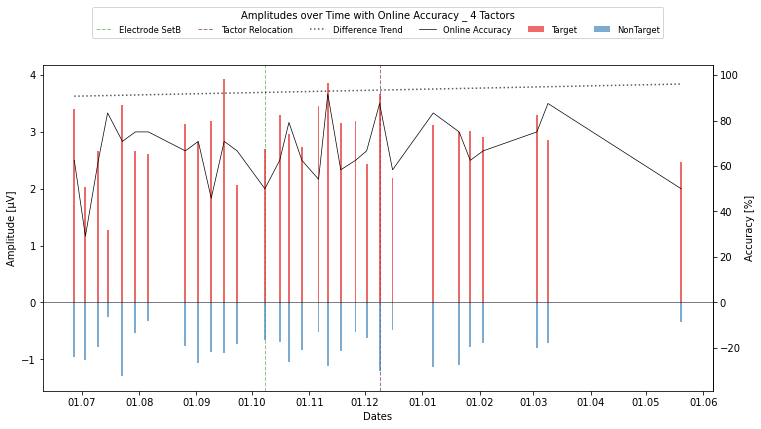

In [101]:
plot_timeline(t_mean,nt_mean,oa,"Cz","Amplitudes over Time with Online Accuracy _ 4 Tactors")

In [48]:
SESS_DATES

{1: '27.06.2019',
 2: '03.07.2019',
 3: '10.07.2019',
 4: '15.07.2019',
 5: '23.07.2019',
 6: '30.07.2019',
 7: '06.08.2019',
 8: '26.08.2019',
 9: '02.09.2019',
 10: '09.09.2019',
 11: '16.09.2019',
 12: '23.09.2019',
 13: '08.10.2019',
 14: '16.10.2019',
 15: '21.10.2019',
 16: '28.10.2019',
 17: '06.11.2019',
 18: '11.11.2019',
 19: '18.11.2019',
 20: '26.11.2019',
 21: '02.12.2019',
 22: '09.12.2019',
 23: '16.12.2019',
 24: '07.01.2020',
 25: '21.01.2020',
 26: '27.01.2020',
 27: '03.02.2020',
 28: '03.03.2020',
 29: '09.03.2020',
 30: '20.05.2020'}

{1: '27.06.2019',
 2: '03.07.2019',
 3: '10.07.2019',
 4: '15.07.2019',
 5: '23.07.2019',
 6: '30.07.2019',
 7: '06.08.2019',
 8: '26.08.2019',
 9: '02.09.2019',
 10: '09.09.2019',
 11: '16.09.2019',
 12: '23.09.2019',
 13: '08.10.2019',
 14: '16.10.2019',
 15: '21.10.2019',
 16: '28.10.2019',
 17: '06.11.2019',
 18: '11.11.2019',
 19: '18.11.2019',
 20: '26.11.2019',
 21: '02.12.2019',
 22: '09.12.2019',
 23: '16.12.2019',
 24: '07.01.2020',
 25: '21.01.2020',
 26: '27.01.2020',
 27: '03.02.2020',
 28: '03.03.2020',
 29: '09.03.2020',
 30: '20.05.2020'}

# Offline Analysis: Classifiers
### Load classification results

In [ ]:
all_acc = pd.read_csv(r"created_data\Classifier_Results\current\accuracies_rightlabel.csv")

In [ ]:
#change NaN values in SWLDA 
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)

In [ ]:

all_acc.loc[all_acc.isnull().any(axis=1)]

In [ ]:
eight_epochs = all_acc.loc[all_acc.Ep2Avg==8]

sess3 = eight_epochs.loc[eight_epochs.Condition=="sess3"]
sess1 = eight_epochs.loc[eight_epochs.Condition=="sess1"]
single3 = eight_epochs.loc[eight_epochs.Condition=="single3"]
single1 = eight_epochs.loc[eight_epochs.Condition=="single1"]


### Boxplots Accuracy

In [ ]:
boxplot_accuracy(eight_epochs,r"All_conditions",r"all_conditions")

In [ ]:
boxplot_accuracy(sess3,r"Sessionwise Calibration - 3 Runs",r"$\bf{Sessionwise}$ Calibration - $\bf{3}$ Runs")

In [ ]:
boxplot_accuracy(sess1,"Sessionwise Calibration - 1 Run",r"$\bf{Sessionwise}$ Calibration - $\bf{1}$ Run")

In [ ]:
boxplot_accuracy(single3,r"Single Calibration - 3 Sessions (9 Runs)",r"$\bf{Single}$ Calibration - 3 Sessions ($\bf{9}$ Runs)")

In [ ]:
boxplot_accuracy(single1,r"Single Calibration - 1 Session (3 Runs)",r"$\bf{Single}$ Calibration - 1 Session ($\bf{3}$ Runs)")

### Classifies: Best/Worst - Sessionwise Ranking

In [ ]:
def Per2Ac_BW(x):
    return x*5

def Ac2Per_BW(x):
    return x/5

In [ ]:
for condition in ["sess3","sess1","single1","single3"]:
    best_performance =pd.DataFrame(columns=["Classifier"])
    worst_performance =pd.DataFrame(columns=["Classifier"])
    for session in range(1,40):
        df = eval(condition).loc[(eval(condition).Ep2Avg==8) &(eval(condition).Session==session)]
        print(session)
        print(df.Accuracy.max())
        print(df.loc[df.Accuracy == df.Accuracy.max()]["Classifier"])
        print("___________________________________")
        best_performance = best_performance.append(df.loc[df.Accuracy == df.Accuracy.max()])
        worst_performance = worst_performance.append(df.loc[df.Accuracy == df.Accuracy.min()])
    performance = pd.DataFrame()
    performance["Accuracy"] = eval(condition).loc[(eval(condition).Ep2Avg==8)].groupby("Classifier").mean().sort_values("Accuracy")["Accuracy"]*20
    performance["Worst"] =worst_performance.groupby("Classifier").count().Accuracy
    performance["Best"] =best_performance.groupby("Classifier").count().Accuracy


    fig, ax = plt.subplots(figsize=(12,8))
    col_list= ["#377eb8","#e41a1c","k"]
    #col_list= ["#d8b365","#5ab4ac","#ef8a62","#67a9cf"]
    y= np.arange(len(performance.index))
    height=0.8
    ax.barh(y- (height/4),performance.Worst, label="Worst",height=height/2, color =col_list[1])
    ax.barh(y+( height/4),performance.Best, label="Best",height=height/2,color =col_list[0])
    ax.scatter(performance.Accuracy,performance.index, alpha=1,label="Average Accuracy", marker ="o",color =col_list[2], s=40,zorder=4)
    ax.plot(performance.Accuracy,performance.index, alpha=1,color =col_list[2])
    ax.set_xticks([0,1,2,3,4,5,10,15,20])
    ax.set_xlabel("Number of Sessions")
    sec_ax = ax.secondary_xaxis("top",functions= (Per2Ac_BW,Ac2Per_BW))
    sec_ax.set_xlabel("Accuracy [%]")
    ax.legend()
    plt.savefig(r"created_data\Graphics\best_worst_"+condition+".png",bbox_inches="tight",pad_inches=0.2,format="png")




# ROC curves

In [ ]:
all_roc = pd.read_csv(r"created_data\Classifier_Results\current\roc.csv")
all_roc["Condition"] = all_roc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
all_roc.to_csv(r"created_data\Classifier_Results\current\roc_rightlabel.csv",index=False)
all_roc["Condition"].isnull().any().sum()

In [ ]:
for condition in np.unique(all_roc.Condition):
    k=0       
    fig, ax = plt.subplots(5,2, figsize=(6,12))
    for i,classifier in enumerate(np.unique(all_roc.Classifier)):
        k = 1 if i>=5 else 0
        roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
        roc["binnedTPR"] = pd.cut(roc.TPR,50)
        roc = roc.groupby("binnedTPR").mean().dropna()
        ax[i-(k*5)][k].plot(roc.FPR,roc.TPR)
        ax[i-(k*5)][k].plot([0,1],[0,1])        
        title = classifier
        ax[i-(k*5)][k].title.set_text(title)
    fig.tight_layout()
    fig.suptitle(condition, y=1)
    plt.savefig(r"created_data\Graphics\roc_"+condition+".svg",bbox_inches="tight",pad_inches=0.2,format="svg")

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
for i,condition in enumerate(np.unique(all_roc.Condition)):
    k = 1 if i>=2 else 0
    ax[i-(k*2)][k].plot([0,1],[0,1], label = "random") 
    for classifier in np.unique(all_roc.Classifier):
        roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
        roc["binnedTPR"] = pd.cut(roc.TPR,50)
        roc = roc.groupby("binnedTPR").mean().dropna()
        ax[i-(k*2)][k].plot(roc.FPR,roc.TPR,label=classifier)
    ax[i-(k*2)][k].title.set_text(condition)
plt.legend()
fig.tight_layout()
plt.savefig(r"created_data\Graphics\roc.svg",bbox_inches="tight",pad_inches=0.2,format="svg")

In [ ]:
np.unique(all_roc.Classifier)